# Self-Driving Car Engineer Nanodegree

## Computer Vision and Deep Learning

### Project: Vehicle Detection

This notebook contains the implementation of the Vehicle Detection project.  The overall goal of this project is to develop a pipeline that will identify vehicles in the view by placing a rectangle around the vehicle.  The project should take steps to minimize false-positives.

# Step 0: Import Statements and Global Variables


In [1]:
'''Consolidated import statements'''
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib_version
import numpy as np
import cv2
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import __version__ as sklearn_version
from skimage import __version__ as skimage_version
import pickle

# Show versions
print("MatPlotLib: " + matplotlib_version)
print("Numpy: " + np.__version__)
print("CV2: " + cv2.__version__)
print("Sklearn: " + sklearn_version)
print("Skimage: " + skimage_version)


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


MatPlotLib: 2.0.0
Numpy: 1.12.0
CV2: 3.1.0
Sklearn: 0.18
Skimage: 0.12.3


# Step 1: Import and Review Labeled Data

Number of car samples: 8792
Number of non-car samples: 8968
Size of first car image: (64, 64, 3)
Size of first non-car image: (64, 64, 3)


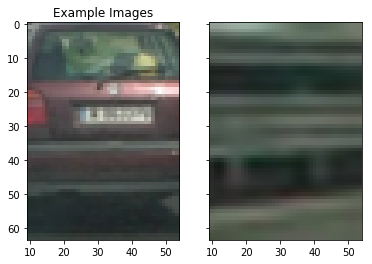

In [3]:
''' This cell creates functions to open labeled data to be used to create a classifier 
    and provides basic statistics
'''

def get_images(vehicle_path='./labeled_data/vehicles/', non_vehicle_path='./labeled_data/non-vehicles/',
               file_type='png'):
    '''
    This function gets list vehicle and non-vehicle images returning two lists accordingly
    
    Parameters
    ----------
    vehicle_path : string, optional
        Path to the vehicle images
    on_vehicle_path : string, optional
        Path to the non-vehicle images
    file_type : string, optional
        File extension to search for in path
        
    Returns
    -------
    cars : list
        List of vehicle image files
    notcars : list
        List of non-vehicle files
    '''
    # Identify path to find image names and find images of the correct type
    search_string = vehicle_path + '**/*.' + file_type
    v_imgs = glob.glob(search_string, recursive=True)
    
    # Add images to list
    cars = []
    for i in v_imgs:
        cars.append(i)
    
    # Do same steps for non-car images
    search_string = non_vehicle_path + '**/*.' + file_type
    nv_imgs = glob.glob(search_string, recursive=True)
    notcars = []
    for i in nv_imgs:
        notcars.append(i)
        
    return cars, notcars

def show_classification_image_stats(cars, notcars):
    '''
    This test function displays to output some basic statistics and info on classification images
    
    Parameters
    ----------
    cars : list
        List of vehicle image files
    notcars : list
        List of non-vehicle files
    '''
    print("Number of car samples: {}".format(len(cars)))
    print("Number of non-car samples: {}".format(len(notcars)))
    
    carimg0 = mpimg.imread(cars[0])
    notcarimg0 = mpimg.imread(notcars[0])
    print("Size of first car image: {}".format(carimg0.shape))
    print("Size of first non-car image: {}".format(notcarimg0.shape))
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(carimg0)
    ax2.imshow(notcarimg0)
    ax1.set_title('Example Images')
    plt.show()
    
cars, notcars = get_images()
show_classification_image_stats(cars, notcars)


# Step 2: Build Feature Extraction Functions

In [4]:
'''This cell defines a class for the classification model.  

The object for this class will hold variousnparameters that will be tuned for the classifiers used.
'''
class ClassifierModel():
    '''
    '''
    def __init__(self):
        # The following object variables are based on initial defaults and will be tweaked
        self.hog_colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL' # Can be 0, 1, 2, or 'ALL'
        self.test_size = 0.2
        
        # These settings are based on SVC Tuning done in the next step
        self.svc_loss = 'squared_hinge'
        self.svc_C = 1.0 #0.0001
        self.svc_tol = 1e-4 #1e-10 # Lower values increase accuracy but increase training time as well

        # Training/test and classifier data (initially blank)
        self.X_train = []
        self.X_test = []
        self.y_train = []
        self.y_test = []
        self.svc = None

    
    def get_hog_features(self, img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
        '''
        This function returns HOG features from an image based on provided parameteres
        Args:
            img: ndarray, image to be processed
            orient: int, number of orientation bins
            pix_per_cell: int, size in pixels of a cell (used for both height and width)
            cell_per_block: int, number of cells in each block (used for height and width)
            vis: bool, default=False, returns image of the HOG features
            feature_vec: bool, default=True, returns data as feature vector
        Returns:
            features: HOG features (flattened if feature_vec==True)
            hog_image: visualization of HOG features, only returned if vis==True
        '''
        # Call with two outputs if vis==True
        if vis:
            features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:
            features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                           visualise=vis, feature_vector=feature_vec)
            return features

    
    def extract_all_features(self, imgs, extract_hog=True):
        # Loop through each image to get all features
        all_features = []
        for file in imgs:
            # Read in image
            image = mpimg.imread(file)
            # Cycle through each feature type, and pull features based on provided parameters
            if extract_hog:
                # Convert color if appropriate
                feature_image = self.cvt_from_rgb(image, self.hog_colorspace)
                # Call get_hog_features() with vis=False, feature_vec=True
                if self.hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(self.get_hog_features(feature_image[:,:,channel],
                                                                  self.orient, self.pix_per_cell, 
                                                                  self.cell_per_block,
                                                                  vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features = self.get_hog_features(feature_image[:,:,self.hog_channel], self.orient,
                                                         self.pix_per_cell, self.cell_per_block, 
                                                         vis=False, feature_vec=True)
                    
            
            # Combine all features into single featurelist for the image
            # TODO Only one feature type for now....
            all_features.append(hog_features)
            
            
        # Return final feature list for all images
        return all_features
        

    def cvt_from_rgb(self, image, cspace):
        # Apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        return feature_image    

    
    def rescale_features(self, features):
        scaler = StandardScaler()
        new_features = scaler.fit_transform(features)
        return new_features
    
    def build_train_test_set(self, car, notcar):
        # Get car and non-car features features
        car_features = self.extract_all_features(car)
        notcar_features = self.extract_all_features(notcar)
        
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        
        # Replace any non-numerical values
        X = np.nan_to_num(X)
        
        # Scale all features
        scaled_X = self.rescale_features(X)
        
        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
        
        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            scaled_X, y, test_size=self.test_size, random_state=rand_state)
        
        return
            
    def create_classifier(self):
        assert self.X_train.size > 0 and self.y_train.size > 0
        self.svc = LinearSVC(loss=self.svc_loss, C=self.svc_C, tol=self.svc_tol)
        self.svc.fit(self.X_train, self.y_train)
        
        

In [20]:
test_img = mpimg.imread(cars[99])
test_c = ClassifierModel()
test_img_luv = test_c.cvt_from_rgb(test_img, 'LUV')
print(test_img_luv[:,:,1])

[[-5.52455425 -5.61140347 -6.18676758 ..., -5.1238575  -5.36248541
  -6.4206996 ]
 [-4.40954065 -5.52455425 -6.32874441 ..., -5.69853067 -5.52590179
  -6.4272604 ]
 [-3.34628272 -5.12353468 -6.57847357 ..., -6.11012459 -4.9431119
  -6.01562405]
 ..., 
 [ 1.87055862  1.86160731  1.27488399 ..., -2.13210583 -4.23529673
  -1.94025433]
 [ 2.63021636  2.02612734  3.72190118 ..., -1.06789577 -3.12067533
  -1.94025433]
 [ 1.97438943  1.97438943  2.57649827 ..., -1.62441039 -3.11699033
  -1.94025433]]


In [30]:
### Cell for testing Class methods
def test_cvt_from_rgb():
    clsfr = ClassifierModel()
    img = mpimg.imread(cars[0])
    img_hls = clsfr.cvt_from_rgb(img, 'HLS')
    img_luv = clsfr.cvt_from_rgb(img, 'LUV')
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    ax1.imshow(img)
    ax1.set_title('Original')
    ax2.imshow(img_hls)
    ax2.set_title('HLS')
    ax3.imshow(img_luv)
    ax3.set_title('LUV')
    plt.show()
    
def test_get_hog_features():
    clsfr = ClassifierModel()
    # Troubleshooting extraing channel 2 features for LUV images
    clsfr.hog_colorspace = 'LUV'
    clsfr.hog_channel = 2
    features = clsfr.extract_all_features(cars[0:3], extract_hog=True)
    
    print(len(features[0]))
    print(features[0])

def test_rescale_features():
    clsfr = ClassifierModel()
    x = [[1, 3, 5], [8, 11, 19], [30, 49, 79]]
    xmin = np.min(x)
    xmax = np.max(x)
    x_scaled = clsfr.rescale_features(x)
    print(x_scaled)
    x_s_min = np.min(x_scaled)
    x_s_max = np.max(x_scaled)
    print("Test variable old min/max: {}/{}; New min/max: {}/{}".format(xmin, xmax, x_s_min, x_s_max))
    
    features = clsfr.extract_all_features(cars[0:3], extract_hog=True)
    fmin = np.min(features)
    fmax = np.max(features)
    f_scaled = clsfr.rescale_features(features)
    f_s_min = np.min(f_scaled)
    f_s_max = np.max(f_scaled)
    print("Features old min/max: {}/{}; New min/max: {}/{}".format(fmin, fmax, f_s_min, f_s_max))
    
def test_build_train_test_set():
    clsfr = ClassifierModel()
    t1 = time.time()
    clsfr.build_train_test_set(cars, notcars)
    t2 = time.time()
    print(round(t2-t1, 2), 'seconds to create train/test set')
    print("Shapes - X_train: {}, X_test: {}, y_train: {}, y_test: {}".format(
        clsfr.X_train.shape, clsfr.X_test.shape, 
        clsfr.y_train.shape, clsfr.y_test.shape))

def test_create_classifier():
    clsfr = ClassifierModel()
    clsfr.build_train_test_set(cars, notcars)
    t2 = time.time()
    clsfr.create_classifier()
    t3 = time.time()
    print(round(t3-t2, 2), 'seconds to create classifier')
    print('Test Accuracy of SVC = ', round(clsfr.svc.score(clsfr.X_test, clsfr.y_test), 4))
    n_predict = 10
    print('My SVC predicts: ', clsfr.svc.predict(clsfr.X_test[0:n_predict]))
    print('For these', n_predict, 'labels: ', clsfr.y_test[0:n_predict])
    t4 = time.time()
    print(round(t4-t3, 5), 'seconds to predict', n_predict, 'labels with SVC')
    

#test_cvt_from_rgb()
test_get_hog_features()
#test_rescale_features()
#test_build_train_test_set()
#test_create_classifier()

1764
[        nan         nan         nan ...,  0.00688125  0.00624748  0.        ]


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:88: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)


# Step 3: Optimize Classifier Training

In [5]:
def tune_hog_features():
    clsfr = ClassifierModel()
    
    p_grid = {'hog_colorspace': ['HLS', 'RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'],
              'orient': [6, 9, 12],
              'pix_per_cell': [4, 8, 12],
              'cell_per_block': [2, 4],
              'hog_channel': [0, 1, 2, 'ALL']}
    
    # Show how many iterations for tuning
    iter_count = 1
    for k, v in p_grid.items():
        iter_count *= len(v)
    print("This tuning has {} iterations:".format(iter_count))
    
    results = {}
    results = run_parameter_options(clsfr, p_grid, results)
    max_param = max(results.keys(), key=(lambda k: results[k]))
    print("Best parameters with a score of {:.3f} were: ".format(results[max_param]))
    print(max_param)
    with open('./hog_tune_results.pickle', 'wb') as h:
        pickle.dump(results, h)

def run_parameter_options(cls, grid, results):
    
    param_name = list(grid.keys())[0]
    param_list = grid[param_name]
    
    local_grid = grid.copy()
    first_iter = True
    for p in param_list:
        if isinstance(p, str): p = "'" + p + "'"
        exec('cls.' + param_name + '=' + str(p))
        
        if len(local_grid) > 1:
            if param_name in local_grid:
                del local_grid[param_name]
    
            results = (run_parameter_options(cls, local_grid, results))
        
        else:
            key = ', '
            key = key.join([cls.hog_colorspace, str(cls.orient), str(cls.pix_per_cell), 
                           str(cls.cell_per_block), str(cls.hog_channel)])
            print((len(results) + 1), '-', key, '- ', end='')

            cls.build_train_test_set(cars, notcars)
            cls.create_classifier()
            results[key] = cls.svc.score(cls.X_test, cls.y_test)
            print(results[key])
            
    return results
    
tune_hog_features()

This tuning has 504 iterations:
1 - HLS, 6, 4, 2, 0 - 0.89527027027
2 - RGB, 6, 4, 2, 0 - 0.936936936937
3 - HSV, 6, 4, 2, 0 - 0.885698198198
4 - LUV, 6, 4, 2, 0 - 0.938063063063
5 - HLS, 6, 4, 2, 0 - 0.894988738739
5 - YUV, 6, 4, 2, 0 - 0.940033783784
6 - YCrCb, 6, 4, 2, 0 - 0.943975225225
7 - YCrCb, 6, 4, 4, 0 - 0.938344594595
8 - HLS, 6, 8, 2, 0 - 0.904560810811
9 - RGB, 6, 8, 2, 0 - 0.931024774775
10 - HSV, 6, 8, 2, 0 - 0.902308558559
11 - LUV, 6, 8, 2, 0 - 0.936373873874
12 - HLS, 6, 8, 2, 0 - 0.914132882883
12 - YUV, 6, 8, 2, 0 - 0.946509009009
13 - YCrCb, 6, 8, 2, 0 - 0.947635135135
14 - YCrCb, 6, 8, 4, 0 - 0.95213963964
15 - HLS, 6, 12, 2, 0 - 0.907376126126
16 - RGB, 6, 12, 2, 0 - 0.930461711712
17 - HSV, 6, 12, 2, 0 - 0.894144144144
18 - LUV, 6, 12, 2, 0 - 0.935247747748
19 - HLS, 6, 12, 2, 0 - 0.890484234234
19 - YUV, 6, 12, 2, 0 - 0.934684684685
20 - YCrCb, 6, 12, 2, 0 - 0.940033783784
21 - YCrCb, 6, 12, 4, 0 - 0.927364864865
22 - HLS, 6, 4, 2, 1 - 0.9375
23 - RGB, 6, 4, 2,

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:88: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)


0.719594594595
26 - HLS, 6, 4, 2, 1 - 0.928490990991
26 - YUV, 6, 4, 2, 1 - 0.91356981982
27 - YCrCb, 6, 4, 2, 1 - 0.914977477477
28 - YCrCb, 6, 4, 4, 1 - 0.928490990991
29 - HLS, 6, 8, 2, 1 - 0.933277027027
30 - RGB, 6, 8, 2, 1 - 0.934684684685
31 - HSV, 6, 8, 2, 1 - 0.907376126126
32 - LUV, 6, 8, 2, 1 - 0.713682432432
33 - HLS, 6, 8, 2, 1 - 0.941722972973
33 - YUV, 6, 8, 2, 1 - 0.932150900901
34 - YCrCb, 6, 8, 2, 1 - 0.946790540541
35 - YCrCb, 6, 8, 4, 1 - 0.935529279279
36 - HLS, 6, 12, 2, 1 - 0.946790540541
37 - RGB, 6, 12, 2, 1 - 0.932713963964
38 - HSV, 6, 12, 2, 1 - 0.875563063063
39 - LUV, 6, 12, 2, 1 - 0.646677927928
40 - HLS, 6, 12, 2, 1 - 0.936373873874
40 - YUV, 6, 12, 2, 1 - 0.952702702703
41 - YCrCb, 6, 12, 2, 1 - 0.941722972973
42 - YCrCb, 6, 12, 4, 1 - 0.940878378378
43 - HLS, 6, 4, 2, 2 - 0.87134009009
44 - RGB, 6, 4, 2, 2 - 0.938344594595
45 - HSV, 6, 4, 2, 2 - 0.935529279279
46 - LUV, 6, 4, 2, 2 - 0.789695945946
47 - HLS, 6, 4, 2, 2 - 0.875281531532
47 - YUV, 6, 4, 2

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:88: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)


(1764,)
[        nan         nan         nan ...,  0.00688125  0.00624748  0.        ]


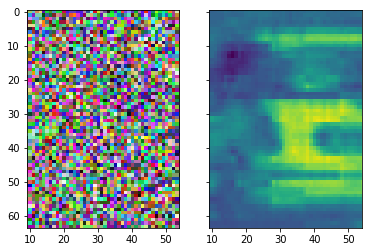

In [29]:
test_c = ClassifierModel()
t_img = mpimg.imread(cars[0])
t_img_luv = test_c.cvt_from_rgb(t_img, 'LUV')
t_img_u = t_img_luv[:,:,2]

test_features = test_c.get_hog_features(t_img_u, test_c.orient, test_c.pix_per_cell, 
                                        test_c.cell_per_block, vis=False, feature_vec=True)
print(test_features.shape)
print(test_features)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(t_img_luv)
ax2.imshow(t_img_u)
plt.show()

In [12]:
def tune_SVC_classifier():
    clsfr = ClassifierModel()
    print('Buidling data set...')
    clsfr.build_train_test_set(cars, notcars)
    
    # Set up possible parameter values
    p_grid = {'C': [0.0000001, 0.00001, 0.0001, 0.1],
              'loss': ['hinge', 'squared_hinge'],
              'tol': [1e-20, 1e-15, 1e-12, 1e-10]}
    
    clsfr.svc = LinearSVC()
    print('Starting grid search...')
    t1 = time.time()
    clf = GridSearchCV(clsfr.svc, p_grid)
    clf.fit(clsfr.X_train, clsfr.y_train)
    t2 = time.time()
    print(round(t2-t1, 2), 'seconds to run GridSearchCV')
    print('Best parameters: \n', clf.best_params_)
    print('Final accuracy: ', clf.score(clsfr.X_test, clsfr.y_test))
    
    
tune_SVC_classifier()    
    

Buidling data set...
Starting grid search...
1444.89 seconds to run GridSearchCV
Best parameters: 
 {'tol': 1e-20, 'C': 0.0001, 'loss': 'squared_hinge'}
Final accuracy:  0.986486486486


# Step 4: Create Sliding Window Identifier on Test Images

# Step 5: Implement Heat Map Flow to Consolidate Regions and Eliminate False Positives

# Step 6: Create Video Pipeline